In [1]:
# where is it ?

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [2]:
train_df_full = pd.read_csv('train.csv')#'/kaggle/input/playground-series-s4e9/train.csv')
test_df_full = pd.read_csv('test.csv')#'/kaggle/input/playground-series-s4e9/test.csv')

In [ ]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

def process_categoricals(df, method, target_col=None):
    """
    Encodes categorical columns based on the chosen method.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        method (str): The encoding method ('integer', 'target', or 'binary').
        target_col (str): The name of the target column for 'target' encoding.
    
    Returns:
        pd.DataFrame: The dataframe with encoded categorical columns.
    """
    df_processed = df.copy()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if method == 'integer':
        # Simple Integer Encoding
        for col in categorical_cols:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
    
    elif method == 'target':
        if target_col is None:
            raise ValueError("For target encoding, a target column must be provided.")
        # Target Encoding
        encoder = ce.TargetEncoder(cols=categorical_cols)
        df_processed[categorical_cols] = encoder.fit_transform(df_processed[categorical_cols], df_processed[target_col])
    
    elif method == 'binary':
        # Binary Encoding
        encoder = ce.BinaryEncoder(cols=categorical_cols)
        df_processed = encoder.fit_transform(df_processed)
    
    else:
        raise ValueError("Invalid method. Choose from 'integer', 'target', or 'binary'.")
    
    return df_processed


Dev fraction: 0.05
Number of trees: 10, Train ROC AUC: 0.9998700840075566, Test ROC AUC: 0.8759194079689543
Number of trees: 30, Train ROC AUC: 0.9999978466962578, Test ROC AUC: 0.8767429267632327
Number of trees: 50, Train ROC AUC: 1.0, Test ROC AUC: 0.8757050674608546
Number of trees: 70, Train ROC AUC: 1.0, Test ROC AUC: 0.8808492396552503
Number of trees: 90, Train ROC AUC: 1.0, Test ROC AUC: 0.8802739046071928
Number of trees: 110, Train ROC AUC: 1.0, Test ROC AUC: 0.8811087044808448
Number of trees: 130, Train ROC AUC: 1.0, Test ROC AUC: 0.8825301204819277
Number of trees: 150, Train ROC AUC: 1.0, Test ROC AUC: 0.8813568882270656
Number of trees: 170, Train ROC AUC: 1.0, Test ROC AUC: 0.884944271467894
Number of trees: 190, Train ROC AUC: 1.0, Test ROC AUC: 0.8847299309597942
Number of trees: 210, Train ROC AUC: 1.0, Test ROC AUC: 0.8861851901989983
Number of trees: 230, Train ROC AUC: 1.0, Test ROC AUC: 0.8891972383917692
Number of trees: 250, Train ROC AUC: 1.0, Test ROC AUC: 0

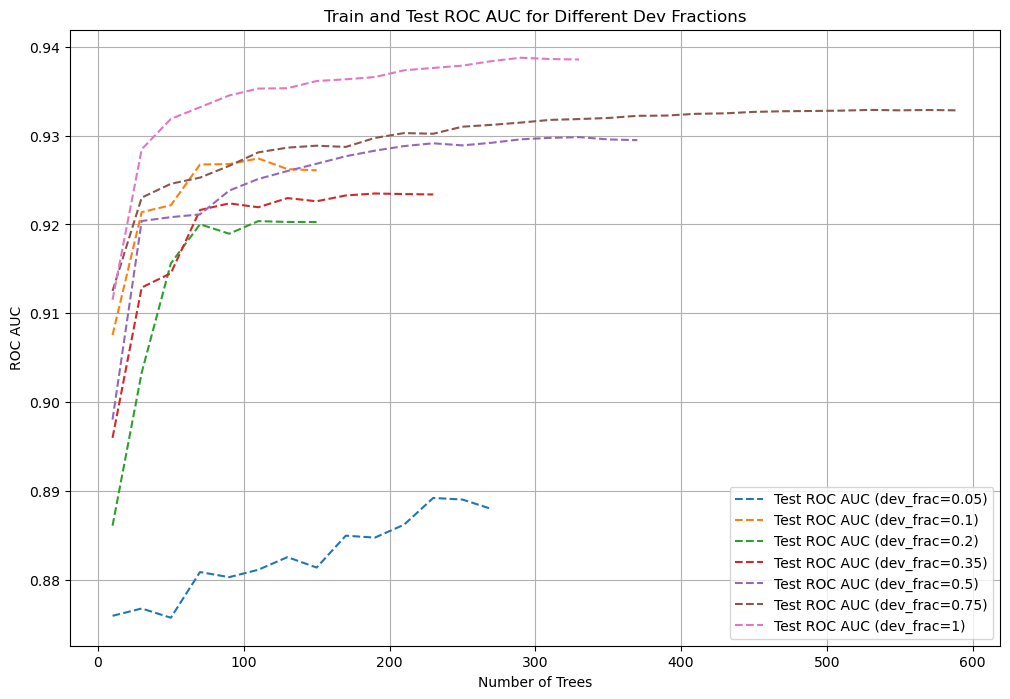

In [6]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

# Set parameters
SEED = 2
TEST_FRAC = 0.2
N_START = 10  # Starting number of trees
dev_fractions = [0.05, 0.1, 0.2, .35, .5, .75, 1]  # Dev set fractions
N_step = 20  # Step for number of trees
N_stop_criteria = 2  # Stop when ROC AUC gets worse for N_stop_criteria times in a row
TARGET = 'loan_status'
CATEGORY_ENCODING = 'integer'  # Options: 'integer', 'target', 'binary'

# Function to process categorical variables
def process_categoricals(df, method, target_col=None):
    df_processed = df.copy()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if method == 'integer':
        # Simple Integer Encoding
        for col in categorical_cols:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
    
    elif method == 'target':
        if target_col is None:
            raise ValueError("For target encoding, a target column must be provided.")
        # Target Encoding
        encoder = ce.TargetEncoder(cols=categorical_cols)
        df_processed[categorical_cols] = encoder.fit_transform(df_processed[categorical_cols], df_processed[target_col])
    
    elif method == 'binary':
        # Binary Encoding
        encoder = ce.BinaryEncoder(cols=categorical_cols)
        df_processed = encoder.fit_transform(df_processed)
    
    else:
        raise ValueError("Invalid method. Choose from 'integer', 'target', or 'binary'.")
    
    return df_processed

# Update the loop to sample development set inside and track train/test scores
def find_optimal_trees_with_tracking(X, y, N_start=10, N_step=20, N_stop_criteria=2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC, random_state=SEED)
    
    num_trees = N_start
    previous_score = -np.inf
    decreases_in_a_row = 0
    best_trees = num_trees
    best_score = -np.inf
    
    train_scores = []
    test_scores = []
    tree_counts = []

    while decreases_in_a_row < N_stop_criteria:
        rf = RandomForestClassifier(n_estimators=num_trees, random_state=SEED)
        rf.fit(X_train, y_train)
        
        # Predict probabilities for train and test sets
        y_train_pred_prob = rf.predict_proba(X_train)[:, 1]
        y_test_pred_prob = rf.predict_proba(X_test)[:, 1]
        
        # Compute ROC AUC for train and test
        train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
        test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

        print(f"Number of trees: {num_trees}, Train ROC AUC: {train_roc_auc}, Test ROC AUC: {test_roc_auc}")
        
        # Track scores
        train_scores.append(train_roc_auc)
        test_scores.append(test_roc_auc)
        tree_counts.append(num_trees)

        if test_roc_auc > best_score:
            best_score = test_roc_auc
            best_trees = num_trees
            decreases_in_a_row = 0
        elif test_roc_auc < previous_score:
            decreases_in_a_row += 1

        previous_score = test_roc_auc
        num_trees += N_step

    return best_trees, best_score, tree_counts, train_scores, test_scores

# Perform the growing search over different dev fractions and record scores
results = {}
for dev_frac in dev_fractions:
    print(f"Dev fraction: {dev_frac}")
    
    # Sample development set for each dev fraction
    df_dev = train_df_full.sample(frac=dev_frac, random_state=SEED)
    
    # Process categorical variables based on the chosen method
    df_dev_encoded = process_categoricals(df_dev, method=CATEGORY_ENCODING, target_col=TARGET)
    
    # Separate features (X) and target (y)
    X = df_dev_encoded.drop(columns=TARGET)
    y = df_dev_encoded[TARGET]
    
    # Find the optimal number of trees with tracking
    best_trees, best_score, tree_counts, train_scores, test_scores = find_optimal_trees_with_tracking(
        X, y, N_start=N_START, N_step=N_step, N_stop_criteria=N_stop_criteria)
    
    results[dev_frac] = (best_trees, best_score, tree_counts, train_scores, test_scores)

# Plot train and test scores for all dev fractions
plt.figure(figsize=(12, 8))

for dev_frac, (best_trees, best_score, tree_counts, train_scores, test_scores) in results.items():
    #plt.plot(tree_counts, train_scores, label=f'Train ROC AUC (dev_frac={dev_frac})')
    plt.plot(tree_counts, test_scores, label=f'Test ROC AUC (dev_frac={dev_frac})', linestyle='--')

plt.xlabel('Number of Trees')
plt.ylabel('ROC AUC')
plt.title('Train and Test ROC AUC for Different Dev Fractions')
plt.legend()
plt.grid(True)
plt.savefig(f'RF_optimization_on_{CATEGORY_ENCODING}.png')
plt.show()


In [11]:
plt.savefig('RF_optimization_on_integer.png')

<Figure size 640x480 with 0 Axes>

## this is with catboost and xgboost comparison included

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from catboost import CatBoostClassifier

# Set parameters
SEED = 3
TEST_FRAC = 0.2
N_START = 10  # Starting number of trees
dev_fractions = [0.05, 0.1, 0.2, .3, .5]  # Dev set fractions
N_step = 50  # Step for number of trees
N_stop_criteria = 2  # Stop when ROC AUC gets worse for N_stop_criteria times in a row
TARGET = 'loan_status'
CATEGORY_ENCODING = 'integer'  # Options: 'integer', 'target', 'binary'

# Function to process categorical variables
def process_categoricals(df, method, target_col=None):
    df_processed = df.copy()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if method == 'integer':
        # Simple Integer Encoding
        for col in categorical_cols:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
    
    elif method == 'target':
        if target_col is None:
            raise ValueError("For target encoding, a target column must be provided.")
        # Target Encoding
        encoder = ce.TargetEncoder(cols=categorical_cols)
        df_processed[categorical_cols] = encoder.fit_transform(df_processed[categorical_cols], df_processed[target_col])
    
    elif method == 'binary':
        # Binary Encoding
        encoder = ce.BinaryEncoder(cols=categorical_cols)
        df_processed = encoder.fit_transform(df_processed)
    
    else:
        raise ValueError("Invalid method. Choose from 'integer', 'target', or 'binary'.")
    
    return df_processed

# Update the loop to sample development set inside and track train/test scores
def find_optimal_trees_with_tracking(X, y, N_start=10, N_step=20, N_stop_criteria=2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC, random_state=SEED)
    
    num_trees = N_start
    previous_score = -np.inf
    decreases_in_a_row = 0
    best_trees = num_trees
    best_score = -np.inf
    
    train_scores = []
    test_scores = []
    tree_counts = []

    while decreases_in_a_row < N_stop_criteria:
        rf = RandomForestClassifier(n_estimators=num_trees, random_state=SEED)
        rf.fit(X_train, y_train)
        
        # Predict probabilities for train and test sets
        y_train_pred_prob = rf.predict_proba(X_train)[:, 1]
        y_test_pred_prob = rf.predict_proba(X_test)[:, 1]
        
        # Compute ROC AUC for train and test
        train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
        test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

        print(f"Number of trees: {num_trees}, Train ROC AUC: {train_roc_auc}, Test ROC AUC: {test_roc_auc}")
        
        # Track scores
        train_scores.append(train_roc_auc)
        test_scores.append(test_roc_auc)
        tree_counts.append(num_trees)

        if test_roc_auc > best_score:
            best_score = test_roc_auc
            best_trees = num_trees
            decreases_in_a_row = 0
        elif test_roc_auc < previous_score:
            decreases_in_a_row += 1

        previous_score = test_roc_auc
        num_trees += N_step

    return best_trees, best_score, tree_counts, train_scores, test_scores

# Add XGBoost and CatBoost baseline models
def xgboost_baseline(X_train, X_test, y_train, y_test):
    xgb_model = xgb.XGBClassifier(random_state=SEED)
    xgb_model.fit(X_train, y_train)
    y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"XGBoost Test ROC AUC: {roc_auc}")
    return roc_auc

def catboost_baseline(X_train, X_test, y_train, y_test):
    catboost_model = CatBoostClassifier(verbose=0, random_state=SEED)
    catboost_model.fit(X_train, y_train)
    y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"CatBoost Test ROC AUC: {roc_auc}")
    return roc_auc

# Perform the growing search over different dev fractions and record scores
results = {}
for dev_frac in dev_fractions:
    print(f"Dev fraction: {dev_frac}")
    
    # Sample development set for each dev fraction
    df_dev = train_df_full.sample(frac=dev_frac, random_state=SEED)
    
    # Process categorical variables based on the chosen method
    df_dev_encoded = process_categoricals(df_dev, method=CATEGORY_ENCODING, target_col=TARGET)
    
    # Separate features (X) and target (y)
    X = df_dev_encoded.drop(columns=TARGET)
    y = df_dev_encoded[TARGET]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC, random_state=SEED)

    # Find the optimal number of trees with tracking
    best_trees, best_score, tree_counts, train_scores, test_scores = find_optimal_trees_with_tracking(
        X, y, N_start=N_START, N_step=N_step, N_stop_criteria=N_stop_criteria)
    
    results[dev_frac] = (best_trees, best_score, tree_counts, train_scores, test_scores)

    # Compare XGBoost and CatBoost baselines
    print(f"\nComparing XGBoost and CatBoost for dev fraction: {dev_frac}")
    xgboost_roc_auc = xgboost_baseline(X_train, X_test, y_train, y_test)
    catboost_roc_auc = catboost_baseline(X_train, X_test, y_train, y_test)
    print(f"Best RF Test ROC AUC: {best_score}\n")

# Plot train and test scores for all dev fractions
plt.figure(figsize=(12, 8))

for dev_frac, (best_trees, best_score, tree_counts, train_scores, test_scores) in results.items():
    #plt.plot(tree_counts, train_scores, label=f'Train ROC AUC (dev_frac={dev_frac})')
    plt.plot(tree_counts, test_scores, label=f'Test ROC AUC (dev_frac={dev_frac})', linestyle='--')

plt.xlabel('Number of Trees')
plt.ylabel('ROC AUC')
plt.title('Train and Test ROC AUC for Different Dev Fractions')
plt.legend()
plt.grid(True)
plt.show()


Dev fraction: 0.05
Number of trees: 10, Train ROC AUC: 0.9999285046715195, Test ROC AUC: 0.884681738593058
Number of trees: 60, Train ROC AUC: 1.0, Test ROC AUC: 0.9129287259244001
Number of trees: 110, Train ROC AUC: 1.0, Test ROC AUC: 0.9193660521165927
Number of trees: 160, Train ROC AUC: 1.0, Test ROC AUC: 0.9208595117931816
Number of trees: 210, Train ROC AUC: 1.0, Test ROC AUC: 0.921541868369554
Number of trees: 260, Train ROC AUC: 1.0, Test ROC AUC: 0.9221469770316201
Number of trees: 310, Train ROC AUC: 1.0, Test ROC AUC: 0.9223400968173859
Number of trees: 360, Train ROC AUC: 1.0, Test ROC AUC: 0.9220826037696982
Number of trees: 410, Train ROC AUC: 1.0, Test ROC AUC: 0.921374497888557

Comparing XGBoost and CatBoost for dev fraction: 0.05
XGBoost Test ROC AUC: 0.9101349263569883
CatBoost Test ROC AUC: 0.9215676176743227
Best RF Test ROC AUC: 0.9223400968173859

Dev fraction: 0.1
Number of trees: 10, Train ROC AUC: 0.9996513944223108, Test ROC AUC: 0.903292156816521
Number of 

KeyboardInterrupt: 

Dev fraction: 0.05
Number of trees: 10, Train ROC AUC: 0.9998489016253763, Test ROC AUC: 0.8930502626429087
Number of trees: 50, Train ROC AUC: 1.0, Test ROC AUC: 0.9202157791739622
Number of trees: 90, Train ROC AUC: 1.0, Test ROC AUC: 0.925944999485014
Number of trees: 130, Train ROC AUC: 1.0, Test ROC AUC: 0.9226748377793799
Number of trees: 170, Train ROC AUC: 1.0, Test ROC AUC: 0.922945205479452

Comparing XGBoost and CatBoost for dev fraction: 0.05
XGBoost Test ROC AUC: 0.9195076732928211
CatBoost Test ROC AUC: 0.9244000411988876
Best RF Test ROC AUC: 0.925944999485014

Dev fraction: 0.1
Number of trees: 10, Train ROC AUC: 0.9997480448576066, Test ROC AUC: 0.8967267026568283
Number of trees: 50, Train ROC AUC: 1.0, Test ROC AUC: 0.9238018340837832
Number of trees: 90, Train ROC AUC: 1.0, Test ROC AUC: 0.924909828143049
Number of trees: 130, Train ROC AUC: 1.0, Test ROC AUC: 0.9274646974233243
Number of trees: 170, Train ROC AUC: 1.0, Test ROC AUC: 0.9285284895919281
Number of tre

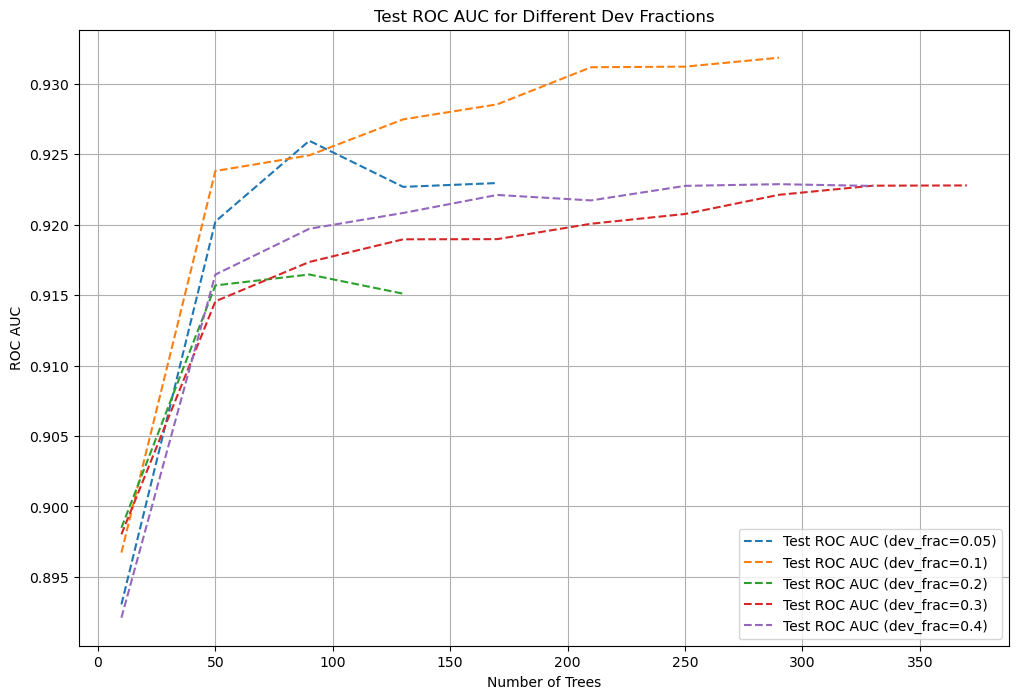

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from catboost import CatBoostClassifier

# Set parameters
SEED = 3
TEST_FRAC = 0.2
N_START = 10  # Starting number of trees
dev_fractions = [0.05, 0.1, 0.2, 0.3, 0.4]  # Dev set fractions
N_step = 40  # Step for number of trees
N_stop_criteria = 2  # Stop when ROC AUC gets worse for N_stop_criteria times in a row
TARGET = 'loan_status'
CATEGORY_ENCODING = 'target'  # Options: 'integer', 'target', 'binary'
eps = 0.001  # Minimum improvement to continue increasing trees

# Function to process categorical variables
def process_categoricals(df, method, target_col=None):
    df_processed = df.copy()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if method == 'integer':
        # Simple Integer Encoding
        for col in categorical_cols:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
    
    elif method == 'target':
        if target_col is None:
            raise ValueError("For target encoding, a target column must be provided.")
        # Target Encoding
        encoder = ce.TargetEncoder(cols=categorical_cols)
        df_processed[categorical_cols] = encoder.fit_transform(df_processed[categorical_cols], df_processed[target_col])
    
    elif method == 'binary':
        # Binary Encoding
        encoder = ce.BinaryEncoder(cols=categorical_cols)
        df_processed = encoder.fit_transform(df_processed)
    
    else:
        raise ValueError("Invalid method. Choose from 'integer', 'target', or 'binary'.")
    
    return df_processed

# Updated function with `eps` for minimum increase
def find_optimal_trees_with_tracking(X, y, N_start=10, N_step=20, N_stop_criteria=2, eps=0.001):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC, random_state=SEED)
    
    num_trees = N_start
    previous_score = -np.inf
    decreases_in_a_row = 0
    best_trees = num_trees
    best_score = -np.inf
    
    train_scores = []
    test_scores = []
    tree_counts = []

    while decreases_in_a_row < N_stop_criteria:
        rf = RandomForestClassifier(n_estimators=num_trees, random_state=SEED)
        rf.fit(X_train, y_train)
        
        # Predict probabilities for train and test sets
        y_train_pred_prob = rf.predict_proba(X_train)[:, 1]
        y_test_pred_prob = rf.predict_proba(X_test)[:, 1]
        
        # Compute ROC AUC for train and test
        train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
        test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

        print(f"Number of trees: {num_trees}, Train ROC AUC: {train_roc_auc}, Test ROC AUC: {test_roc_auc}")
        
        # Track scores
        train_scores.append(train_roc_auc)
        test_scores.append(test_roc_auc)
        tree_counts.append(num_trees)

        # Check if the improvement is greater than the minimum threshold (eps)
        if test_roc_auc - previous_score > eps:
            best_score = test_roc_auc
            best_trees = num_trees
            decreases_in_a_row = 0
        elif test_roc_auc < previous_score or (test_roc_auc - previous_score <= eps):
            decreases_in_a_row += 1

        previous_score = test_roc_auc
        num_trees += N_step

    return best_trees, best_score, tree_counts, train_scores, test_scores

# Add XGBoost and CatBoost baseline models
def xgboost_baseline(X_train, X_test, y_train, y_test):
    xgb_model = xgb.XGBClassifier(random_state=SEED)
    xgb_model.fit(X_train, y_train)
    y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"XGBoost Test ROC AUC: {roc_auc}")
    return roc_auc

def catboost_baseline(X_train, X_test, y_train, y_test):
    catboost_model = CatBoostClassifier(verbose=0, random_state=SEED)
    catboost_model.fit(X_train, y_train)
    y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"CatBoost Test ROC AUC: {roc_auc}")
    return roc_auc

# Perform the growing search over different dev fractions and record scores
results = {}
for dev_frac in dev_fractions:
    print(f"Dev fraction: {dev_frac}")
    
    # Sample development set for each dev fraction
    df_dev = train_df_full.sample(frac=dev_frac, random_state=SEED)
    
    # Process categorical variables based on the chosen method
    df_dev_encoded = process_categoricals(df_dev, method=CATEGORY_ENCODING, target_col=TARGET)
    
    # Separate features (X) and target (y)
    X = df_dev_encoded.drop(columns=TARGET)
    y = df_dev_encoded[TARGET]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC, random_state=SEED)

    # Find the optimal number of trees with tracking
    best_trees, best_score, tree_counts, train_scores, test_scores = find_optimal_trees_with_tracking(
        X, y, N_start=N_START, N_step=N_step, N_stop_criteria=N_stop_criteria, eps=eps)
    
    results[dev_frac] = (best_trees, best_score, tree_counts, train_scores, test_scores)

    # Compare XGBoost and CatBoost baselines
    print(f"\nComparing XGBoost and CatBoost for dev fraction: {dev_frac}")
    xgboost_roc_auc = xgboost_baseline(X_train, X_test, y_train, y_test)
    catboost_roc_auc = catboost_baseline(X_train, X_test, y_train, y_test)
    print(f"Best RF Test ROC AUC: {best_score}\n")

# Plot train and test scores for all dev fractions
plt.figure(figsize=(12, 8))

for dev_frac, (best_trees, best_score, tree_counts, train_scores, test_scores) in results.items():
    plt.plot(tree_counts, test_scores, label=f'Test ROC AUC (dev_frac={dev_frac})', linestyle='--')

plt.xlabel('Number of Trees')
plt.ylabel('ROC AUC')
plt.title('Test ROC AUC for Different Dev Fractions')
plt.legend()
plt.grid(True)
plt.savefig(f'RF_optimization_on_{CATEGORY_ENCODING}.png')
plt.show()


## Catboost dubbing for integer

# producing the output

In [19]:
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd

# Step 1: Preprocess the data (categorical encoding)
df_dev_encoded = process_categoricals(train_df_full, method=CATEGORY_ENCODING, target_col=TARGET)

# Step 2: Separate features (X) and target (y) from the full training set
X_train = df_dev_encoded.drop(columns=[TARGET, 'id'])
y_train = df_dev_encoded[TARGET]

# Step 3: Create and fit the CatBoost model (pipeline not needed as we manually processed the data)
model = CatBoostClassifier(verbose=0, random_state=SEED)
model.fit(X_train, y_train)

# Step 4: Prepare test data (assuming test_df_full needs the same encoding)
df_test_encoded = process_categoricals(test_df_full, method=CATEGORY_ENCODING)  # Same preprocessing for test set
X_test = df_test_encoded.drop(columns='id')  # Drop any unwanted columns like 'id'

# Step 5: Make predictions
predictions = model.predict_proba(X_test)[:, 1]

# Step 6: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_df_full['id'],  # Preserve 'id' from the test set
    TARGET: predictions       # The predicted prices
})

# Step 7: Save the submission to a CSV file
submission.to_csv('submissions/submission1_IntegerCatboostDefault.csv', index=False)

In [ ]:
from catboost import CatBoostClassifier
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Step 1: Separate features (X) and target (y) from the full training set
X_train_full = train_df_full.drop(columns=[TARGET, 'id'])
y_train_full = train_df_full[TARGET]

# Step 2: Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=SEED)

# Step 3: Fit the TargetEncoder on the training data only
encoder = ce.TargetEncoder(cols=X_train.select_dtypes(include=['object', 'category']).columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Step 4: Apply the fitted encoder to the validation set (without refitting)
X_valid_encoded = encoder.transform(X_valid)

# Step 5: Create and fit the CatBoost model on the encoded training data
model = CatBoostClassifier(verbose=0, random_state=SEED)
model.fit(X_train_encoded, y_train)

# Step 6: Prepare test data and apply the same target encoding
X_test = test_df_full.drop(columns='id')  # Assuming 'id' is present in the test set
X_test_encoded = encoder.transform(X_test)  # Apply the encoder fitted on the training set

# Step 7: Make predictions
predictions = model.predict_proba(X_test_encoded)[:, 1]  # Probabilities for class 1

# Step 8: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_df_full['id'],  # Preserve 'id' from the test set
    TARGET: predictions       # The predicted probabilities (logits percentage)
})

# Step 9: Save the submission to a CSV file
submission.to_csv('submissions/submission1_IntegerCatboostDefault.csv', index=False)
